This tutorial is generated from a [Jupyter](http://jupyter.org/) notebook that can be found [here](https://github.com/elfi-dev/notebooks). 

# ELFI tutorial

This tutorial covers the basics of using ELFI, i.e. how to make models, save results for later use and run different inference algorithms.

Let's begin by importing libraries that we will use and specify some settings.

In [1]:
import time

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)  # sometimes this is required to enable logging inside Jupyter

%matplotlib inline
%precision 2

# Set an arbitrary seed and a global random state to keep the randomly generated quantities the same between runs
seed = 20170530
np.random.seed(seed)

## Inference with ELFI: case MA(2) model

Throughout this tutorial we will use the 2nd order moving average model MA(2) as an example. MA(2) is a common model used in univariate time series analysis. Assuming zero mean it can be written as

$$
y_t = w_t + \theta_1 w_{t-1} + \theta_2 w_{t-2},
$$

where $\theta_1, \theta_2 \in \mathbb{R}$ and $(w_k)_{k\in \mathbb{Z}} \sim N(0,1)$ represents an independent and identically distributed sequence of white noise.

### The observed data and the inference problem

In this tutorial, our task is to infer the parameters $\theta_1, \theta_2$ given a sequence of 100 observations $y$ that originate from an MA(2) process. Let's define the MA(2) simulator as a Python function:

In [2]:
def MA2(t1, t2, n_obs=100, batch_size=1, random_state=None):
    # Make inputs 2d arrays for numpy broadcasting with w
    t1 = np.asanyarray(t1).reshape((-1, 1))
    t2 = np.asanyarray(t2).reshape((-1, 1))
    random_state = random_state or np.random

    w = random_state.randn(batch_size, n_obs+2)  # i.i.d. sequence ~ N(0,1)
    x = w[:, 2:] + t1*w[:, 1:-1] + t2*w[:, :-2]
    return x

Above, `t1`, `t2`, and `n_obs` are the arguments specific to the MA2 process. The latter two, `batch_size` and `random_state` are ELFI specific keyword arguments. The `batch_size` argument tells how many simulations are needed. The `random_state` argument is for generating random quantities in your simulator. It is a `numpy.RandomState` object that has all the same methods as `numpy.random` module has. It is used for ensuring consistent results and handling random number generation in parallel settings.

### Vectorization

What is the purpose of the `batch_size` argument? In ELFI, operations are vectorized, meaning that instead of simulating a single MA2 sequence at a time, we simulate a *batch* of them. A vectorized function takes vectors as inputs, and computes the output for each element in the vector. Vectorization is a way to make operations efficient in Python. 

In the MA2 simulator above we rely on numpy to carry out the vectorized calculations. The arguments `t1` and `t2` are going to be **vectors** of length `batch_size` and the function returns a 2D array of shape `(batch_size, n_obs)` with each row corresponding to a single argument pair. Notice that for convenience, the funtion also works with scalars as they are first converted to vectors.

Let's now use this simulator to create toy observations. We will use parameter values $\theta_1=0.6, \theta_2=0.2$ as in [*Marin et al. (2012)*](http://link.springer.com/article/10.1007/s11222-011-9288-2) and then try to infer these parameter values back based on the toy observed data alone.

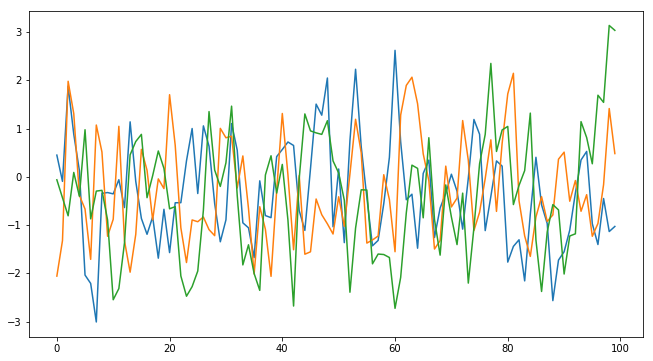

In [3]:
# true parameters
t1_true = 0.6
t2_true = 0.2

y_obs = MA2(t1_true, t2_true)

# Plot the observed sequence
plt.figure(figsize=(11, 6));
plt.plot(y_obs.ravel());

# To illustrate the stochasticity, let's plot a couple of more observations with the same true parameters:
plt.plot(MA2(t1_true, t2_true).ravel());
plt.plot(MA2(t1_true, t2_true).ravel());

### Approximate Bayesian Computation

Standard statistical inference methods rely on the use of the *likelihood* function. Given a configuration of the parameters, the likelihood function quantifies how likely it is that values of the parameters produced the observed data. In our simple example case above however, evaluating the likelihood is difficult due to the unobserved latent sequence (variable `w` in the simulator code). In many real world applications the likelihood function is not available or it is too expensive to evaluate preventing the use of traditional inference methods.

One way to approach this problem is to use Approximate Bayesian Computation (ABC) which is a statistically based method replacing the use of the likelihood function with a simulator of the data. Loosely speaking, it is based on the intuition that similar data is likely to have been produced by similar parameters. Looking at the picture above, in essence we would keep simulating until we have found enough sequences that are similar to the observed sequence. Although the idea may appear inapplicable for the task at hand, you will soon see that it does work. For more information about ABC, please see e.g. 

* [Lintusaari, J., Gutmann, M. U., Dutta, R., Kaski, S., and Corander, J. (2016). Fundamentals and recent
developments in approximate Bayesian computation. *Systematic Biology*, doi: 10.1093/sysbio/syw077.](http://sysbio.oxfordjournals.org/content/early/2016/09/07/sysbio.syw077.full.pdf)

* [Marin, J.-M., Pudlo, P., Robert, C. P., and Ryder, R. J. (2012). Approximate Bayesian computational
methods. *Statistics and Computing*, 22(6):1167–1180.](http://link.springer.com/article/10.1007/s11222-011-9288-2)

* https://en.wikipedia.org/wiki/Approximate_Bayesian_computation

## Defining the model

ELFI includes an easy to use generative modeling syntax, where the generative model is specified as a directed acyclic graph ([DAG](https://en.wikipedia.org/wiki/Directed_acyclic_graph)). This provides an intuitive means to describe rather complex dependencies conveniently. Often the target of the generative model is a distance between the simulated and observed data. To start creating our model, we will first import ELFI:

In [4]:
import elfi

As is usual in Bayesian statistical inference, we need to define *prior* distributions for the unknown parameters $\theta_1, \theta_2$. In ELFI the priors can be any of the continuous and discrete distributions available in `scipy.stats` (for custom priors, see [below](#Custom-priors)). For simplicity, let's start by assuming that both parameters follow `Uniform(0, 2)`.

In [5]:
# a node is defined by giving a distribution from scipy.stats together with any arguments (here 0 and 2)
t1 = elfi.Prior(scipy.stats.uniform, 0, 2)

# ELFI also supports giving the scipy.stats distributions as strings
t2 = elfi.Prior('uniform', 0, 2)

Next, we define the *simulator* node with the `MA2` function above, and give the priors to it as arguments. This means that the parameters for the simulations will be drawn from the priors. Because we have the observed data available for this node, we provide it here as well:

In [6]:
Y = elfi.Simulator(MA2, t1, t2, observed=y_obs)

But how does one compare the simulated sequences with the observed sequence? Looking at the plot of just a few observed sequences above, a direct pointwise comparison would probably not work very well: the three sequences look quite different although they were generated with the same parameter values. Indeed, the comparison of simulated sequences is often the most difficult (and ad hoc) part of ABC. Typically one chooses one or more summary statistics and then calculates the discrepancy between those.

Here, we will apply the intuition arising from the definition of the MA(2) process, and use the autocovariances with lags 1 and 2 as the summary statistics. Note that since the rows of `x` correspond to independent simulations, we have to tell this numpy function to take row-wise means by the keyword argument `axis=1`:

In [7]:
def autocov(x, lag=1):
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1)
    return C

As is familiar by now, a `Summary` node is defined by giving the autocovariance function and the simulated data (which includes the observed as well):

In [8]:
S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov, Y, 2)  # the optional keyword lag is given the value 2

Here, we choose the discrepancy as the common Euclidean L2-distance. ELFI can use many common distances directly from `scipy.spatial.distance` like this:

In [9]:
# Finish the model with the final node that calculates the squared distance (S1_sim-S1_obs)**2 + (S2_sim-S2_obs)**2
d = elfi.Distance('euclidean', S1, S2)

One may wish to use a distance function that is unavailable in `scipy.spatial.distance`. ELFI supports defining a custom distance/discrepancy functions as well (see the documentation for `elfi.Distance` and `elfi.Discrepancy`).

Now that the inference model is defined, ELFI can visualize the model as a DAG. 

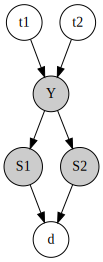

In [10]:
elfi.draw(d)  # just give it a node in the model, or the model itself (d.model)

## Modifying the model

Although the above definition is perfectly valid, let's use the same priors as in [*Marin et al. (2012)*](http://link.springer.com/article/10.1007/s11222-011-9288-2) that guarantee that the problem will be identifiable (loosely speaking, the likelihood willl have just one mode). Marin et al. used priors for which $-2<\theta_1<2$ with $\theta_1+\theta_2>-1$ and $\theta_1-\theta_2<1$ i.e. the parameters are sampled from a triangle (see below).

### Custom priors

In ELFI, custom distributions can be defined similar to distributions in `scipy.stats` (i.e. they need to have at least the `rvs` method implemented for the simplest algorithms). To be safe they can inherit `elfi.Distribution` which defines the methods needed. In this case we only need these for sampling, so implementing a static `rvs` method suffices. As was in the context of simulators, it is important to accept the keyword argument `random_state`, which is needed for ELFI's internal book-keeping of pseudo-random number generation. Also the `size` keyword is needed (which in the simple cases is the same as the `batch_size` in the simulator definition).

In [11]:
# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class CustomPrior_t1(elfi.Distribution):
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1

# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class CustomPrior_t2(elfi.Distribution):
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2

These indeed sample from a triangle:

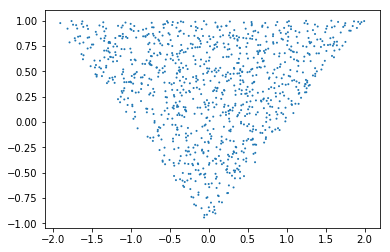

In [12]:
t1_1000 = CustomPrior_t1.rvs(2, 1000)
t2_1000 = CustomPrior_t2.rvs(t1_1000, 1, 1000)
plt.scatter(t1_1000, t2_1000, s=4, edgecolor='none');
# plt.plot([0, 2, -2, 0], [-1, 1, 1, -1], 'b')  # outlines of the triangle

Let's change the earlier priors to the new ones in the inference model:

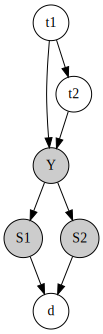

In [13]:
t1.become(elfi.Prior(CustomPrior_t1, 2))
t2.become(elfi.Prior(CustomPrior_t2, t1, 1))

elfi.draw(d)

Note that `t2` now depends on `t1`. Yes, ELFI supports hierarchy.

## Inference with rejection sampling

The simplest ABC algorithm samples parameters from their prior distributions, runs the simulator with these and compares them to the observations. The samples are either accepted or rejected depending on how large the distance is. The accepted samples represent samples from the approximate posterior distribution.

In ELFI, ABC methods are initialized either with a node giving the distance, or with the `ElfiModel` object and the name of the distance node. Depending on the inference method, additional arguments may be accepted or required. 

A common optional keyword argument, accepted by all inference methods, `batch_size` defines how many simulations are performed in each passing through the graph. 

Another optional keyword is the seed. This ensures that the outcome will be always the same for the same data and model. If you leave it out, a random seed will be taken. Giving `seed='global'` will use the global numpy seed.

In [14]:
rej = elfi.Rejection(d, batch_size=10000, seed=seed)

After the ABC method has been initialized, samples can be drawn from it. By default, rejection sampling in ELFI works in `quantile` mode i.e. a certain quantile of the samples with smallest discrepancies is accepted. The `sample` method requires the number of output samples as a parameter. Note that the simulator is then run `(N/quantile)` times. (Alternatively, the same behavior can be achieved by saying `n_sim=1000000`.)

The IPython magic command `%time` is used here to give you an idea of runtime on a typical personal computer. We will turn interactive visualization on so that if you run this on a notebook you will see the posterior forming from a prior distribution. In this case most of the time is spent in drawing.

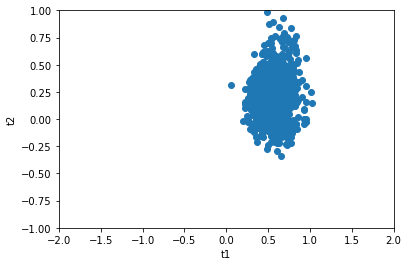

CPU times: user 1.89 s, sys: 173 ms, total: 2.06 s
Wall time: 2.13 s


In [15]:
N = 1000

vis = dict(xlim=[-2,2], ylim=[-1,1])

# You can give the sample method a `vis` keyword to see an animation how the prior transforms towards the
# posterior with a decreasing threshold.
%time result = rej.sample(N, quantile=0.01, vis=vis)

The `sample` method returns a `Sample` object, which contains several attributes and methods. Most notably the attribute `samples` contains an `OrderedDict` (i.e. an ordered Python dictionary) of the posterior numpy arrays for all the model parameters (`elfi.Prior`s in the model). For rejection sampling, other attributes include e.g. the `threshold`, which is the threshold value resulting in the requested quantile. 

In [16]:
result.samples['t1'].mean()

0.55600915483879665

The `Sample` object includes a convenient `summary` method:

In [17]:
result.summary()

Method: Rejection
Number of samples: 1000
Number of simulations: 100000
Threshold: 0.117
Sample means: t1: 0.556, t2: 0.219


Rejection sampling can also be performed with using a threshold or total number of simulations. Let's define here threshold. This means that all draws from the prior for which the generated distance is below the threshold will be accepted as samples. Note that the simulator will run as long as it takes to generate the requested number of samples.

In [18]:
%time result2 = rej.sample(N, threshold=0.2)

print(result2)  # the Sample object's __str__ contains the output from summary()

CPU times: user 221 ms, sys: 40 ms, total: 261 ms
Wall time: 278 ms
Method: Rejection
Number of samples: 1000
Number of simulations: 40000
Threshold: 0.185
Sample means: t1: 0.555, t2: 0.223



## Iterative advancing

Often it may not be practical to wait to the end before investigating the results. There may be time constraints or one may wish to check the results at certain intervals. For this, ELFI provides an iterative approach to advance the inference. First one sets the objective of the inference and then calls the `iterate` method.

Below is an example how to run the inference until the objective has been reached or a maximum of one second of time has been used.

In [19]:
# Request for 1M simulations.
rej.set_objective(1000, n_sim=1000000)

# We only have 1 sec of time and we are unsure if we will be finished by that time. 
# So lets simulate as many as we can.

time0 = time.time()
time1 = time0 + 1
while not rej.finished and time.time() < time1:
    rej.iterate()
    # One could investigate the rej.state or rej.extract_result() here
    # to make more complicated stopping criterions
    
# Extract and print the result as it stands. It will show us how many simulations were generated.
print(rej.extract_result())

Method: Rejection
Number of samples: 1000
Number of simulations: 130000
Threshold: 0.104
Sample means: t1: 0.558, t2: 0.219



In [20]:
# We will see that it was not finished in 1 sec
rej.finished

False

We could continue from this stage just by continuing to call the `iterate` method. The `extract_result` will always give a proper result even if the objective was not reached. 

Next we will look into how to store all the data that was generated so far. This allows us to e.g. save the data to disk and continue the next day, or modify the model and reuse some of the earlier data if applicable.

## Storing simulated data

As the samples are already in numpy arrays, you can just say e.g. `np.save('t1_data.npy', result.samples['t1'])` to save them. However, ELFI provides some additional functionality. You may define a *pool* for storing all outputs of any node in the model (not just the accepted samples). Let's save all outputs for `t1`, `t2`, `S1` and `S2` in our model:

In [21]:
pool = elfi.OutputPool(['t1', 't2', 'S1', 'S2'])
rej = elfi.Rejection(d, batch_size=10000, pool=pool)

%time result3 = rej.sample(N, n_sim=1000000)
result3

CPU times: user 6.13 s, sys: 1.15 s, total: 7.29 s
Wall time: 8.57 s


Method: Rejection
Number of samples: 1000
Number of simulations: 1000000
Threshold: 0.0364
Sample means: t1: 0.557, t2: 0.211

The benefit of the pool is that you may reuse simulations without having to resimulate them. Above we saved the summaries to the pool, so we can change the distance node of the model without having to resimulate anything. Let's do that.

In [22]:
# Replace the current distance with a cityblock (manhattan) distance and recreate the inference
d.become(elfi.Distance('cityblock', S1, S2, p=1))
rej = elfi.Rejection(d, batch_size=10000, pool=pool)

%time result4 = rej.sample(N, n_sim=1000000)
result4

CPU times: user 161 ms, sys: 2.84 ms, total: 163 ms
Wall time: 167 ms


Method: Rejection
Number of samples: 1000
Number of simulations: 1000000
Threshold: 0.0456
Sample means: t1: 0.56, t2: 0.214

Note the significant saving in time, even though the total number of considered simulations stayed the same. 

We can also continue the inference by increasing the total number of simulations and only have to simulate the new ones:

In [23]:
%time result5 = rej.sample(N, n_sim=1200000)
result5

CPU times: user 1.14 s, sys: 185 ms, total: 1.33 s
Wall time: 1.34 s


Method: Rejection
Number of samples: 1000
Number of simulations: 1200000
Threshold: 0.0415
Sample means: t1: 0.56, t2: 0.216

Above the results were saved into a python dictionary. If you store a lot of data to dictionaries, you will eventually run out of memory. ELFI provides an alternative pool that, by default, saves the outputs to standard numpy .npy files:

In [24]:
arraypool = elfi.ArrayPool(['t1', 't2', 'Y', 'd'])
rej = elfi.Rejection(d, batch_size=10000, pool=arraypool)
%time result5 = rej.sample(100, threshold=0.3)

CPU times: user 66.6 ms, sys: 70.3 ms, total: 137 ms
Wall time: 175 ms


This stores the simulated data in binary `npy` format under `arraypool.path`, and can be loaded with `np.load`. 

In [25]:
# Let's flush the outputs to disk (alternatively you can save or close the pool) so that we can read the .npy files.
arraypool.flush()

import os
print('Files in', arraypool.path, 'are', os.listdir(arraypool.path))

Files in pools/arraypool_4290044000 are ['d.npy', 't1.npy', 't2.npy', 'Y.npy']


Now lets load all the parameters `t1` that were generated with numpy:

In [26]:
np.load(arraypool.path + '/t1.npy')

array([ 0.42, -1.15,  1.3 , ...,  0.64,  1.06, -0.47])

We can also close (or save) the whole pool if we wish to continue later:

In [27]:
arraypool.close()
name = arraypool.name
print(name)

arraypool_4290044000


And open it up later to continue where we were left. We can open it using its name:

In [28]:
arraypool = elfi.ArrayPool.open(name)
print('This pool has', len(arraypool), 'batches')

# This would give the contents of the first batch
# arraypool[0]

This pool has 1 batches


You can delete the files with:

In [29]:
arraypool.delete()

# verify the deletion
try:
    os.listdir(arraypool.path)
    
except FileNotFoundError:
    print("The directory is removed")

The directory is removed


## Visualizing the results

Instances of `Sample` contain methods for some basic plotting (these are convenience methods to plotting functions defined under `elfi.visualization`).

For example one can plot the marginal distributions:

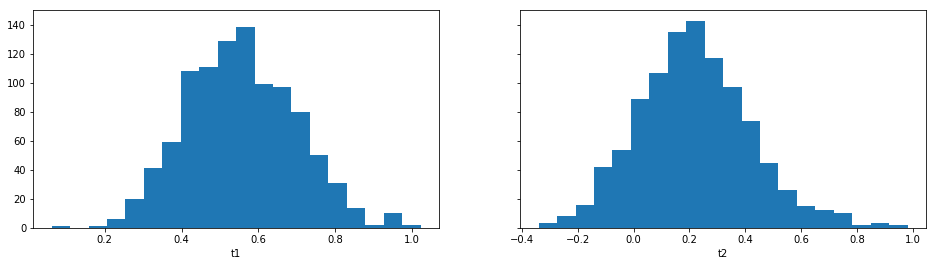

In [30]:
result.plot_marginals();

Often "pairwise relationships" are more informative:

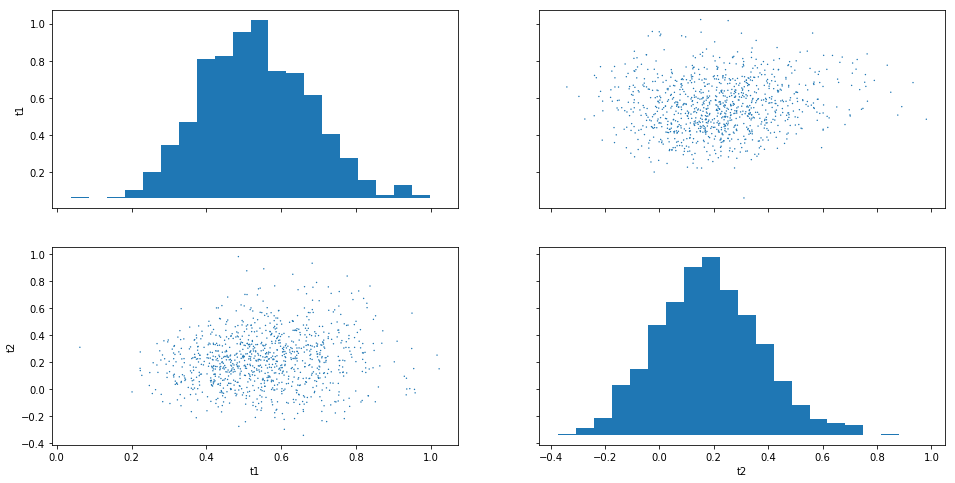

In [31]:
result.plot_pairs();

Note that if working in a non-interactive environment, you can use e.g. `plt.savefig('pairs.png')` after an ELFI plotting command to save the current figure to disk.

## Sequential Monte Carlo ABC

Rejection sampling is quite inefficient, as it does not learn from its history. The sequential Monte Carlo (SMC) ABC algorithm does just that by applying importance sampling: samples are *weighed* according to the resulting discrepancies and the next *population* of samples is drawn near to the previous using the weights as probabilities. 

For evaluating the weights, SMC ABC needs to be able to compute the probability density of the generated parameters. In our MA2 example we used custom priors, so we have to specify a `pdf` function by ourselves. If we used standard priors, this step would not be needed. Let's modify the prior distribution classes:

In [32]:
# define prior for t1 as in Marin et al., 2012 with t1 in range [-b, b]
class CustomPrior_t1(elfi.Distribution):
    def rvs(b, size=1, random_state=None):
        u = scipy.stats.uniform.rvs(loc=0, scale=1, size=size, random_state=random_state)
        t1 = np.where(u<0.5, np.sqrt(2.*u)*b-b, -np.sqrt(2.*(1.-u))*b+b)
        return t1
    
    def pdf(x, b):
        p = 1./b - np.abs(x) / (b*b)
        p = np.where(p < 0., 0., p)  # disallow values outside of [-b, b] (affects weights only)
        return p

    
# define prior for t2 conditionally on t1 as in Marin et al., 2012, in range [-a, a]
class CustomPrior_t2(elfi.Distribution):
    def rvs(t1, a, size=1, random_state=None):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        t2 = scipy.stats.uniform.rvs(loc=locs, scale=scales, size=size, random_state=random_state)
        return t2
    
    def pdf(x, t1, a):
        locs = np.maximum(-a-t1, t1-a)
        scales = a - locs
        p = scipy.stats.uniform.pdf(x, loc=locs, scale=scales)
        p = np.where(scales>0., p, 0.)  # disallow values outside of [-a, a] (affects weights only)
        return p
    
    
# Redefine the priors
t1.become(elfi.Prior(CustomPrior_t1, 2, model=t1.model))
t2.become(elfi.Prior(CustomPrior_t2, t1, 1))

### Run SMC ABC

In ELFI, one can setup a SMC ABC sampler just like the Rejection sampler:

In [33]:
smc = elfi.SMC(d, batch_size=10000, seed=seed)

For sampling, one has to define the number of output samples, the number of populations and a *schedule* i.e. a list of thresholds to use for each population. In essence, a population is just refined rejection sampling.

In [34]:
N = 1000
schedule = [0.7, 0.2, 0.05]
%time result_smc = smc.sample(N, schedule)

INFO:elfi.methods.parameter_inference:---------------- Starting round 0 ----------------
INFO:elfi.methods.parameter_inference:---------------- Starting round 1 ----------------
INFO:elfi.methods.parameter_inference:---------------- Starting round 2 ----------------


CPU times: user 1.72 s, sys: 183 ms, total: 1.9 s
Wall time: 1.65 s


We can have summaries and plots of the results just like above:

In [35]:
result_smc.summary(all=True)

Method: SMC
Number of samples: 1000
Number of simulations: 170000
Threshold: 0.0493
Sample means: t1: 0.554, t2: 0.229

Population 0:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 10000
Threshold: 0.488
Sample means: t1: 0.547, t2: 0.232

Population 1:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 20000
Threshold: 0.172
Sample means: t1: 0.562, t2: 0.22

Population 2:
Method: Rejection within SMC-ABC
Number of samples: 1000
Number of simulations: 140000
Threshold: 0.0493
Sample means: t1: 0.554, t2: 0.229


Or just the means:

In [36]:
result_smc.sample_means_summary(all=True)

Sample means for population 0: t1: 0.547, t2: 0.232
Sample means for population 1: t1: 0.562, t2: 0.22
Sample means for population 2: t1: 0.554, t2: 0.229



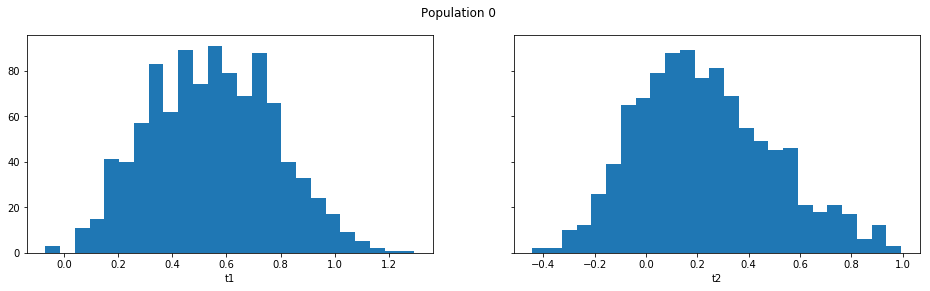

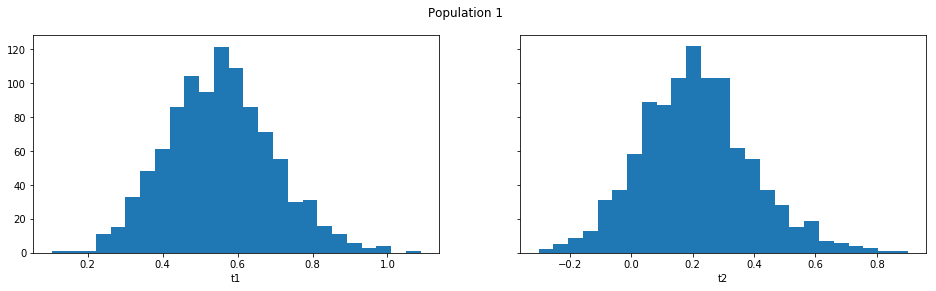

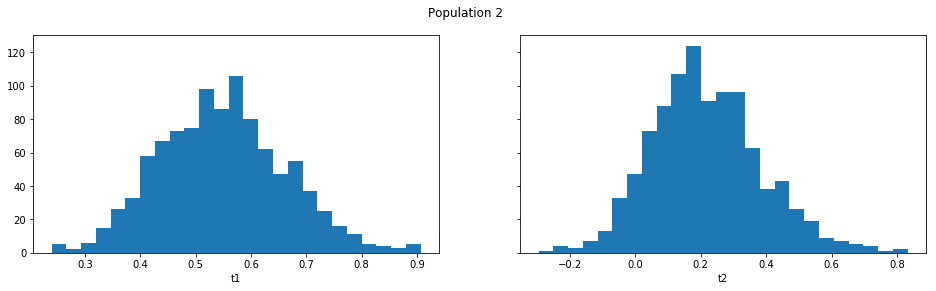

In [37]:
result_smc.plot_marginals(all=True, bins=25, figsize=(8, 2), fontsize=12)

Obviously one still has direct access to the samples as well, which allows custom plotting:

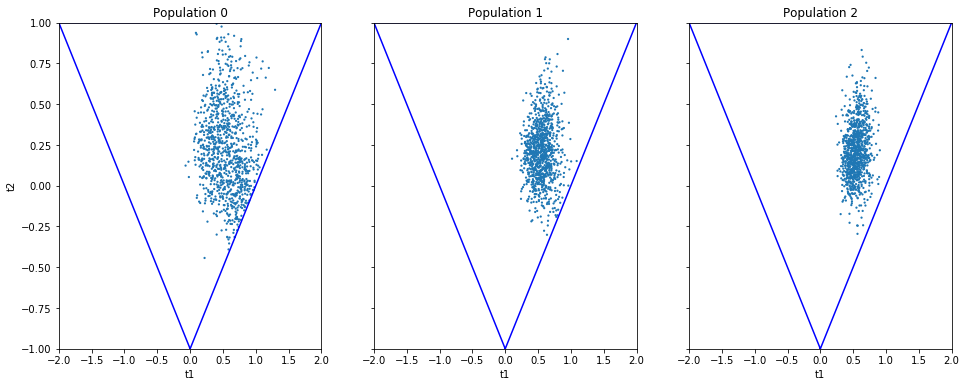

In [38]:
n_populations = len(schedule)
fig, ax = plt.subplots(ncols=n_populations, sharex=True, sharey=True, figsize=(16,6))

for i, pop in enumerate(result_smc.populations):
    s = pop.samples
    ax[i].scatter(s['t1'], s['t2'], s=5, edgecolor='none');
    ax[i].set_title("Population {}".format(i));
    ax[i].plot([0, 2, -2, 0], [-1, 1, 1, -1], 'b')
    ax[i].set_xlabel('t1');
ax[0].set_ylabel('t2');
ax[0].set_xlim([-2, 2])
ax[0].set_ylim([-1, 1]);

It can be seen that the populations iteratively concentrate more and more around the true parameter values. Note, however, that samples from SMC are weighed, and the weights should be accounted for when interpreting the results. ELFI does this automatically when computing the mean, for example.

## What next?

If you want to play with different ABC algorithms, no need to repeat the simulator definitions etc. from this notebook. ELFI provides a convenient way to quickly get you going:

In [39]:
from elfi.examples import ma2
ma2_model = ma2.get_model()

This constructs the same ELFI graph discussed in this tutorial. The example is self-contained and includes implementations of all relevant operations.

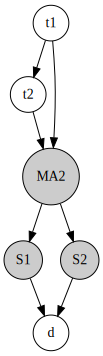

In [40]:
elfi.draw(ma2_model)

In [41]:
elfi.Rejection(ma2_model['d'], batch_size=10000).sample(1000)

Method: Rejection
Number of samples: 1000
Number of simulations: 100000
Threshold: 0.128
Sample means: t1: 0.719, t2: 0.412

ELFI ships with many other common example cases from ABC literature, and they all include the `get_model` method mentioned above. The source codes of these examples are also good for learning more about best practices with ELFI.

In [42]:
!ls {elfi.examples.__path__[0] + '/*.py'} | xargs basename

__init__.py
bdm.py
bignk.py
gauss.py
gnk.py
lotka_volterra.py
ma2.py
ricker.py


That's it! See the other documentation for more advanced topics on e.g. BOLFI, external simulators and parallelization.